<p id = 'toc'></p>

<h1 style = "font-family:Verdana; font-size:24px; font-weight: bold; letter-spacing: 3px; color: teal;"> TABLE OF CONTENTS </h1>

---

[<h3 style = "font-family: Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal">0&nbsp;&nbsp;&nbsp;&nbsp; IMPORTS </h3>](#0)

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#1'>1.&nbsp;&nbsp;&nbsp;&nbsp;DATASET</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#2'>2.&nbsp;&nbsp;&nbsp;&nbsp;CONVERTING IMAGE DATA TO JPG</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#3'>3.&nbsp;&nbsp;&nbsp;&nbsp;VISUALIZATIONS</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#4'>4.&nbsp;&nbsp;&nbsp;&nbsp;DATA LOADER</a></h3>


# <span><center style = "display: fill; border-radius: 40px; background-color:  #ecf0f1 ; font-family: Times New Roman; font-size:45px; color : black; letter-spacing: 3px; font-weight: bold; padding: 10px">0. &nbsp;IMPORTS&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc' style = 'color : black'>&#10514;</a></center></span>

In [1]:
# pip install pydicom

In [31]:
import pandas as pd 
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

import cv2
import shutil
import random

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix, f1_score

from imblearn.over_sampling import RandomOverSampler

from IPython.display import display
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image
# from pydicom import dcmread
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

In [3]:
class config:
    TRAIN_CSV = 'train.csv'
    TEST_CSV = 'sample_submission.csv'
    TRAIN_JPG_PATH = './unifesp-xray-body-resize-270/dataset/train'
    TEST_JPG_PATH = './unifesp-xray-body-resize-270/dataset/test'
    RANDOM_SEED = 15
    resize_size = [270,270]
    img_size = [256,256]
    train_bs = 32
    val_bs = 64
    device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
    
config.device

device(type='cuda', index=0)

In [4]:
def set_seed(seed = config.RANDOM_SEED):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print("--> SEEDING DONE")
    
    
set_seed()

--> SEEDING DONE


# <span><center style = "display: fill; border-radius: 40px; background-color:  #ecf0f1 ; font-family: Times New Roman; font-size:45px; color : black; letter-spacing: 3px; font-weight: bold; padding: 10px" id = '1'>1.&nbsp;&nbsp;DATASET&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc' style = 'color : black'>&#10514;</a></center></span>

In [5]:
train_df = pd.read_csv(config.TRAIN_CSV)
test_df = pd.read_csv(config.TEST_CSV)
print('Traning dataframe')
display(train_df.head())
print()
print('Submission dataframe')
display(test_df.head())

Traning dataframe


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3



Submission dataframe


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [6]:
def image_path_creation(path, replace_part, name_of_file_column = 'SOPInstanceUID'):
    '''
    : params
    path: directory path
    replace_part: Remove the suffix of files and save only the name of that file 

    This function iterate through the path and read all files available in that path and 
    returns dataframe containing name of file and path of that file
    
    '''

    file_names = []
    full_paths = []
    for dirpath,  dirname, filenames in os.walk(path):
        if filenames:
            for filename in filenames:
                full_path = os.path.join(dirpath, filename)
                filename = filename.replace(replace_part, '')
                full_paths.append(full_path)
                file_names.append(filename)
    image_path_dict = {name_of_file_column: file_names, 'path':full_paths}
    image_df = pd.DataFrame(image_path_dict)
    return image_df

In [7]:
image_df = image_path_creation(config.TRAIN_JPG_PATH, '.jpg')
train_df=pd.merge(train_df, image_df, on = 'SOPInstanceUID')
train_df.head(8)

,SOPInstanceUID,Target,path
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,./unifesp-xray-body-resize-270/dataset/train\1...
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,./unifesp-xray-body-resize-270/dataset/train\1...
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,./unifesp-xray-body-resize-270/dataset/train\1...
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,./unifesp-xray-body-resize-270/dataset/train\1...
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,./unifesp-xray-body-resize-270/dataset/train\1...
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3,./unifesp-xray-body-resize-270/dataset/train\1...
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14,./unifesp-xray-body-resize-270/dataset/train\1...
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20,./unifesp-xray-body-resize-270/dataset/train\1...


In [8]:
train_df.shape

(1738, 3)

In [9]:
image_df = image_path_creation(config.TEST_JPG_PATH, '.jpg')
test_df = pd.merge(test_df, image_df, on = 'SOPInstanceUID')

In [10]:
test_df.head()

,SOPInstanceUID,Target,path
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./unifesp-xray-body-resize-270/dataset/test\1....
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./unifesp-xray-body-resize-270/dataset/test\1....
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./unifesp-xray-body-resize-270/dataset/test\1....
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./unifesp-xray-body-resize-270/dataset/test\1....
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./unifesp-xray-body-resize-270/dataset/test\1....


In [11]:
test_df.shape

(743, 3)

<a id="2"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">2.&nbsp;&nbsp;CONVERTING IMAGE DATA TO JPG&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

In [12]:
# def read_dicom_image(path):
#     '''
#         Function created to read dicom file from path    
#     '''
#     dicom_file = dcmread(path)
#     image = dicom_file.pixel_array
#     image = image/image.max()
#     return image

# def save_image_jpg(path, save_path_name):
#     image = read_dicom_image(path)*255
#     plt.imsave(save_path_name, image)

In [13]:
# Saving jpg images to working directory

# os.mkdir('./train')

# for i in tqdm(range(1000, train_df.shape[0])):
#     save_image_jpg(train_df.path[i], f'./train/{train_df.SOPInstanceUID[i]}.jpg')

In [14]:
# file_names, file_paths = image_path_creation(config.TRAIN_JPG_PATH, '.jpg')
# image_df = {'SOPInstanceUID': file_names, 'pathle_paths}
# image_df = pd.DataFrame(image_df)

In [15]:
# os.listdir(config.TRAIN_JPG_PATH)

In [16]:
# image_df#, train_df.SOPInstanceUID[0]

In [17]:
# train_df_jpg=pd.merge(train_df, image_df, on = 'SOPInstanceUID')

In [18]:
# file_names, file_paths = image_path_creation(config.TEST_JPG_PATH, '.jpg')
# image_df = {'SOPInstanceUID': file_names, 'path':file_paths}
# image_df = pd.DataFrame(image_df)

In [19]:
# test_df=pd.merge(test_df, image_df, on = 'SOPInstanceUID')

# <span><center style = "display: fill; border-radius: 40px; background-color:  #ecf0f1 ; font-family: Times New Roman; font-size:45px; color : black; letter-spacing: 3px; font-weight: bold; padding: 10px" id = '3'>3.&nbsp;&nbsp;DATA EXPLORATION AND VISUALIZATIONS&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc' style = 'color : black'>&#10514;</a></center></span>

## <span><center style="text-indent: 2vw;color:black; display:fill; border-radius:30px; background-color: #ecf0f1 ; font-size:30px; font-family:Nexa; letter-spacing:0.5px; padding: 10px; text-align:left" id = '3.1'><b>3.1 | One-Hot Encoding </b></center></span>

In [20]:
train_df.Target.value_counts()

3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

<div style="margin: 2em; line-height: 1.7em; font-family: Times New Roman; font-size: 20px; color:black">
    <b style="font-size: 25px;">🦉 &nbsp; Observation and Conclusion:</b><br><br>- We have <b>Multi-label classification</b> problem, that is one image can belongs to one or many classes <br>
    - So first we find out how many observations are there having multiple labels, then we Convert them from obj type to int and store in list. <br>
    - Then we use one-hot encoding to encode the labels, so that we can use those columns to solve classification problem.
</div>


In [21]:
train_df.dtypes

SOPInstanceUID    object
Target            object
path              object
dtype: object

In [22]:
train_df['label_count']=train_df.Target.map(lambda x: len(x.split()))

In [23]:
train_df['Target_list']=train_df.Target.map(lambda x: [int(i) for i in x.split()])

Y = train_df['Target_list']

multilabel_encoder = MultiLabelBinarizer()
Y_transformed=multilabel_encoder.fit_transform(Y)
label_columns = []

for i in range(Y_transformed.shape[1]):
    name = f'label_{i}'
    train_df[name] = Y_transformed[:,i]
    label_columns.append(name)

In [24]:
label_columns = [column for column in train_df.columns if 'label_' in column]

In [25]:
label_columns = label_columns[1:]

In [26]:
train_df.head(8)

,SOPInstanceUID,Target,path,label_count,Target_list,label_0,label_1,label_2,label_3,label_4,...,label_12,label_13,label_14,label_15,label_16,label_17,label_18,label_19,label_20,label_21
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,./unifesp-xray-body-resize-270/dataset/train\1...,1,[0],1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,./unifesp-xray-body-resize-270/dataset/train\1...,1,[15],0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,./unifesp-xray-body-resize-270/dataset/train\1...,1,[12],0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,./unifesp-xray-body-resize-270/dataset/train\1...,1,[14],0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,./unifesp-xray-body-resize-270/dataset/train\1...,1,[3],0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3,./unifesp-xray-body-resize-270/dataset/train\1...,1,[3],0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14,./unifesp-xray-body-resize-270/dataset/train\1...,1,[14],0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20,./unifesp-xray-body-resize-270/dataset/train\1...,2,"[13, 20]",0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## <span><center style="text-indent: 2vw;color:black; display:fill; border-radius:30px; background-color: #ecf0f1 ; font-size:30px; font-family:Nexa; letter-spacing:0.5px; padding: 10px; text-align:left" id = '3.2'><b>3.2 | Visualizing some images </b></center></span>

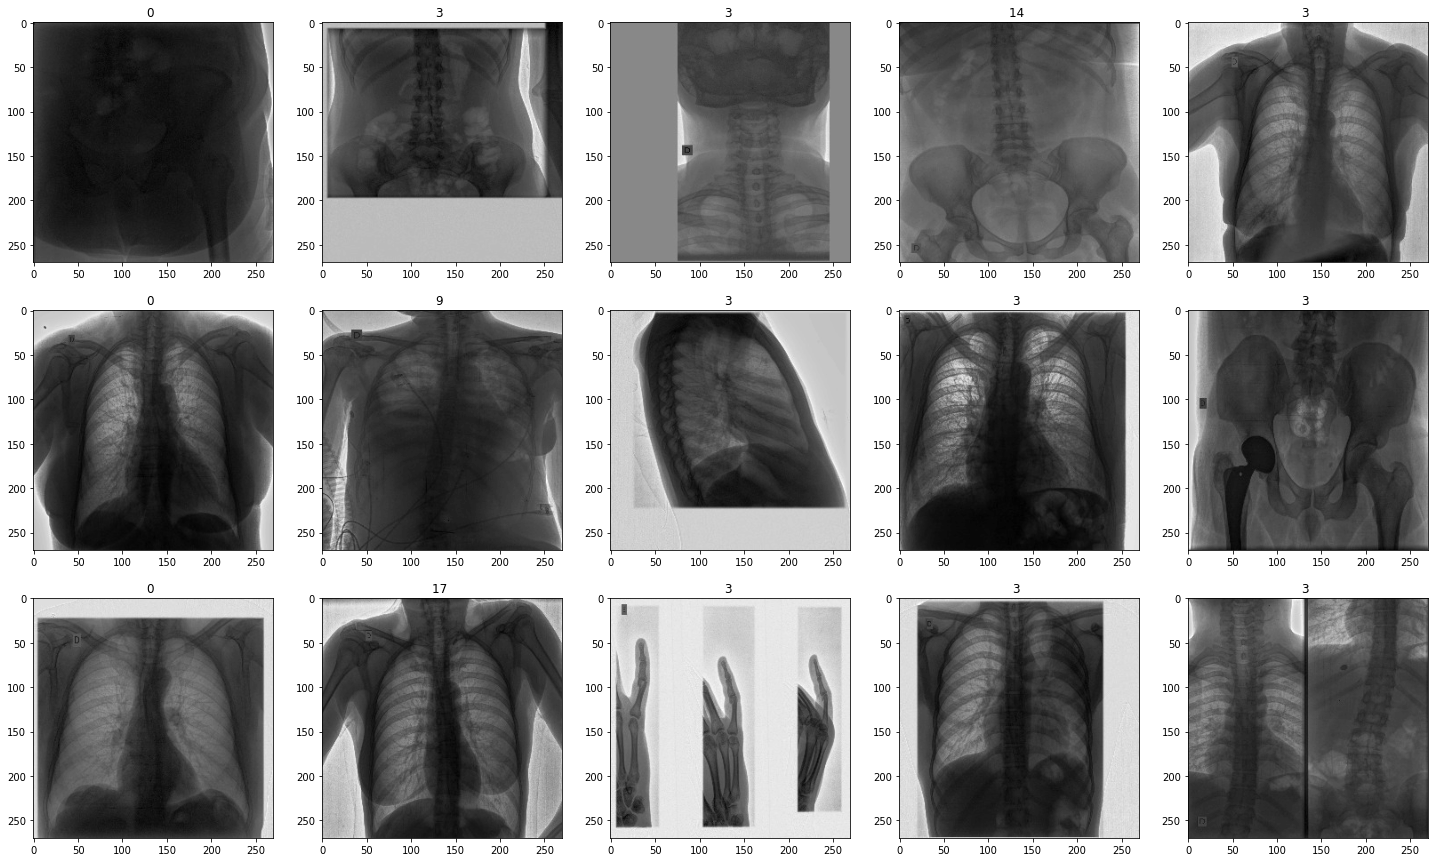

In [27]:
fig = plt.figure(figsize=(25,15))
for i in range(15):
    ax = fig.add_subplot(3,5, i+1)
#     image = read_dicom_image(train_df.path[i*5])
    img = np.array(Image.open(train_df.path[i*50]))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img, cmap = 'gray')
    ax.set_title(train_df.Target[i*5])

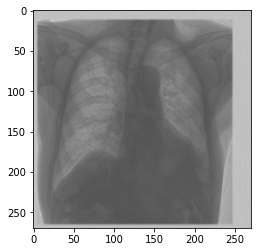

In [28]:
img = cv2.imread(train_df.path[5])
plt.imshow(img)

## <span><center style="text-indent: 2vw;color:black; display:fill; border-radius:30px; background-color: #ecf0f1 ; font-size:30px; font-family:Nexa; letter-spacing:0.5px; padding: 10px; text-align:left" id = '3.3'><b>3.3 | Checking for Imbalance classes </b></center></span>

<div style="margin: 2em; line-height: 1.7em; font-family: Times New Roman; font-size: 20px; color:black">
    <b style="font-size: 25px;">🥣 &nbsp; Procedure:</b><br><br>- Now we have total 21 classes, but there are some images having multiple labels and we have to take care of those imbalancement also <br>
    - Please Note that the dataset images are incorrectly labeled, but I am going to ignore that because I am just doing practice <br>
</div>

In [29]:
px.bar(x = train_df.columns[-22:], y = train_df.iloc[:,-22:].sum(axis = 0))

In [30]:
px.bar(x = train_df.Target_list.value_counts().index.map(lambda x: str(x)),
             y = train_df.Target_list.value_counts())

In [32]:
random_sampler = RandomOverSampler()

In [39]:
train_df.columns

Index(['SOPInstanceUID', 'Target', 'path', 'label_count', 'Target_list',
       'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5',
       'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11',
       'label_12', 'label_13', 'label_14', 'label_15', 'label_16', 'label_17',
       'label_18', 'label_19', 'label_20', 'label_21'],
      dtype='object')

In [40]:
list_of_colms = ['SOPInstanceUID', 'path', 'label_count', 'Target_list',
       'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5',
       'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11',
       'label_12', 'label_13', 'label_14', 'label_15', 'label_16', 'label_17',
       'label_18', 'label_19', 'label_20', 'label_21']

X, Y=random_sampler.fit_resample(train_df[list_of_colms], train_df.Target )

In [44]:
balanced_train_df = pd.DataFrame(X)
balanced_train_df['Target'] = Y

print('Top rows')
display(balanced_train_df.head())

Top rows


,SOPInstanceUID,path,label_count,Target_list,label_0,label_1,label_2,label_3,label_4,label_5,...,label_13,label_14,label_15,label_16,label_17,label_18,label_19,label_20,label_21,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,./unifesp-xray-body-resize-270/dataset/train\1...,1,[0],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,./unifesp-xray-body-resize-270/dataset/train\1...,1,[15],0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,./unifesp-xray-body-resize-270/dataset/train\1...,1,[12],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,./unifesp-xray-body-resize-270/dataset/train\1...,1,[14],0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,./unifesp-xray-body-resize-270/dataset/train\1...,1,[3],0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3


In [45]:
px.bar(x = balanced_train_df.Target_list.value_counts().index.map(lambda x: str(x)),
             y = balanced_train_df.Target_list.value_counts())

In [46]:
balanced_train_df.columns

Index(['SOPInstanceUID', 'path', 'label_count', 'Target_list', 'label_0',
       'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6',
       'label_7', 'label_8', 'label_9', 'label_10', 'label_11', 'label_12',
       'label_13', 'label_14', 'label_15', 'label_16', 'label_17', 'label_18',
       'label_19', 'label_20', 'label_21', 'Target'],
      dtype='object')

In [47]:
px.bar(y = balanced_train_df.iloc[:,-23:-1].sum(axis = 0), x = balanced_train_df.columns[-23:-1])

<a id="4"></a>

# <span><center style = "display: fill; border-radius: 40px; background-color:  #ecf0f1 ; font-family: Times New Roman; font-size:45px; color : black; letter-spacing: 3px; font-weight: bold; padding: 10px">4.&nbsp;&nbsp;SAVING RESIZED IMAGES&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc' style = 'color : black'>&#10514;</a></center></span>


<div style="margin: 2em; line-height: 1.7em; font-family: Times New Roman; font-size: 20px; color:black">
    <b style="font-size: 25px;">🥣 &nbsp; Procedure:</b><br><br>- Following commented code is used to save the resized jpg files, so that working on personal computer is possible and it will be easy to download
</div>

In [34]:
# import os

In [35]:
# T = '../input/unifesp-xray-body-resize-270'
# !zip -r data_file.zip ../input/unifesp-xray-body-resize-270

In [36]:
# image = cv2.imread(train_df.path[5])
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, config.resize_size)

In [37]:
# config.resize_size

In [38]:
# plt.imshow(image, cmap = 'gray')

In [39]:
# # save resized images

# def save_resized_images(img_path):
#     image = cv2.imread(img_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = cv2.resize(image, config.resize_size)
#     return image

In [40]:
# os.mkdir('./dataset')
# os.mkdir('./dataset/train')
# os.mkdir('./dataset/test')

In [41]:
# train_df.columns

In [42]:
# for i in tqdm(range(train_df.shape[0])):
#     image = save_resized_images(train_df['path'][i])
#     cv2.imwrite(f'./dataset/train/{train_df.SOPInstanceUID[i]}.jpg', image)
    
# for i in tqdm(range(test_df.shape[0])):
#     image = save_resized_images(test_df['path'][i])
#     cv2.imwrite(f'./dataset/test/{test_df.SOPInstanceUID[i]}.jpg', image)

In [43]:
# len(os.listdir('./dataset/test'))

<a id="5"></a>

# <span><center style = "display: fill; border-radius: 40px; background-color:  #ecf0f1 ; font-family: Times New Roman; font-size:45px; color : black; letter-spacing: 3px; font-weight: bold; padding: 10px">5.&nbsp;&nbsp;DATA LOADER&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc' style = 'color : black'>&#10514;</a></center></span>


In [30]:
cv2.imread(train_df.path[0]).shape

(270, 270, 3)

In [45]:
# Custom dataset

class CustomeImageDataset(Dataset):
    
    def __init__(self, data_frame, path_col, label_col, transform = None):
        self.path  = data_frame[path_col]
        self.label = data_frame[label_col]
        self.transform = transform
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        img_path = self.path[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = np.expand_dims(image, axis = 0)
        label = self.label.iloc[idx].to_numpy()
        label = torch.from_numpy(label)
        label = label.to(torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

In [46]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(config.resize_size),
    transforms.CenterCrop(config.img_size),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.3),
    transforms.ToTensor()
])

In [47]:
config.img_size, config.resize_size

([256, 256], [270, 270])

In [48]:
image_dataset = CustomeImageDataset(train_df, 'path', label_columns, transform)

In [49]:
# Creating dataset for training and validation=

valid_size = 0.3


num_train = len(image_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(num_train * valid_size))
train_idx, val_idx =  indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(image_dataset, batch_size = 16, 
                      sampler = train_sampler)
val_loader = DataLoader(image_dataset, batch_size = 16,
                       sampler = val_sampler)

In [50]:
images, labels = next(iter(train_loader))

In [51]:
images.shape, labels.shape

(torch.Size([16, 1, 256, 256]), torch.Size([16, 22]))

In [52]:
labels.dtype

torch.float32

<a id="5"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">5.&nbsp;&nbsp;MODEL BUILDING&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

In [53]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size= 3, padding = 1)
        self.conv2 = nn.Conv2d(8,16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(32,64, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(64,128, kernel_size = 3, padding = 1)
        self.conv6 = nn.Conv2d(128,256, kernel_size = 3, padding = 1)
        self.conv7 = nn.Conv2d(256,260, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(260*2*2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64,22)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = x.view(-1, 260*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        
        return x
        
        
        
model = Classifier()
print(model)

Classifier(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 260, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1040, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=22, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [54]:
model(images[0:1]).shape

torch.Size([1, 22])

In [55]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

In [57]:
# model.to(config.device)

In [58]:
# torch.cuda.is_available()

In [ ]:
# model.cuda()

In [59]:
# Load models

state_dict_model = torch.load('model_save.pt')
print(state_dict_model.keys())
model.load_state_dict(state_dict_model)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


<All keys matched successfully>

In [ ]:
# torch.save(model.state_dict(), 'model_save.pt')

In [61]:
running_test_loss = 0
for images, labels in val_loader:
        model.eval()
        # images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        running_test_loss += loss

In [64]:
valid_loss_min=running_test_loss/len(val_loader)

In [65]:
epochs = 20
training_loss = []
testing_loss = []
# valid_loss_min = np.Inf

model.train()
for e in tqdm(range(epochs)):
    running_train_loss = 0
    running_test_loss = 0
    for ee, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss
            
    for images, labels in val_loader:
        model.eval()
        # images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        running_test_loss += loss
    
    train_loss = running_train_loss/len(train_loader)
    valid_loss = running_test_loss/len(val_loader)
    
    print('Epoch {} \tTraining loss: {:.6f} \tValidation Loss: {:.6}'.format(
            e, train_loss, valid_loss))

    if valid_loss <=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f})\t Saving model'.format(
                valid_loss_min, valid_loss))
        torch.save(model.state_dict(), './model_save.pt')
        valid_loss_min = valid_loss

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 	Training loss: 0.047473 	Validation Loss: 0.0763241


  5%|▌         | 1/20 [02:58<56:22, 178.01s/it]

Epoch 1 	Training loss: 0.044667 	Validation Loss: 0.0759794


 15%|█▌        | 3/20 [10:12<54:49, 193.49s/it]  

Epoch 2 	Training loss: 0.039864 	Validation Loss: 0.077169


 20%|██        | 4/20 [11:36<40:06, 150.43s/it]

Epoch 3 	Training loss: 0.034688 	Validation Loss: 0.0774931


 25%|██▌       | 5/20 [12:57<31:17, 125.16s/it]

Epoch 4 	Training loss: 0.035963 	Validation Loss: 0.0887322


 30%|███       | 6/20 [14:31<26:46, 114.78s/it]

Epoch 5 	Training loss: 0.033588 	Validation Loss: 0.0822667


 35%|███▌      | 7/20 [15:50<22:17, 102.91s/it]

Epoch 6 	Training loss: 0.031569 	Validation Loss: 0.0777132


 40%|████      | 8/20 [17:03<18:40, 93.40s/it] 

Epoch 7 	Training loss: 0.038971 	Validation Loss: 0.0781913


 45%|████▌     | 9/20 [19:03<18:38, 101.66s/it]

Epoch 8 	Training loss: 0.027005 	Validation Loss: 0.0851586
Epoch 9 	Training loss: 0.027507 	Validation Loss: 0.0803569


 55%|█████▌    | 11/20 [30:17<31:36, 210.71s/it]

Epoch 10 	Training loss: 0.030877 	Validation Loss: 0.0800859


 60%|██████    | 12/20 [31:40<22:55, 172.00s/it]

Epoch 11 	Training loss: 0.024278 	Validation Loss: 0.0820489


 65%|██████▌   | 13/20 [33:08<17:04, 146.39s/it]

Epoch 12 	Training loss: 0.020913 	Validation Loss: 0.0850057


 70%|███████   | 14/20 [34:23<12:29, 124.97s/it]

Epoch 13 	Training loss: 0.022274 	Validation Loss: 0.101667


 75%|███████▌  | 15/20 [35:35<09:04, 108.93s/it]

Epoch 14 	Training loss: 0.020872 	Validation Loss: 0.0849913


 80%|████████  | 16/20 [36:51<06:35, 98.92s/it] 

Epoch 15 	Training loss: 0.021689 	Validation Loss: 0.081687


 85%|████████▌ | 17/20 [38:07<04:35, 91.93s/it]

Epoch 16 	Training loss: 0.018809 	Validation Loss: 0.101692


 90%|█████████ | 18/20 [39:12<02:47, 83.91s/it]

Epoch 17 	Training loss: 0.016333 	Validation Loss: 0.0933639


 95%|█████████▌| 19/20 [40:29<01:21, 81.94s/it]

Epoch 18 	Training loss: 0.016966 	Validation Loss: 0.0890505


100%|██████████| 20/20 [41:58<00:00, 125.90s/it]

Epoch 19 	Training loss: 0.016492 	Validation Loss: 0.0952036


In [66]:
torch.save( model.state_dict(), 'overfit_model_complex.pt')

In [67]:
images, labels = next(iter(train_loader))

In [68]:
images[0].max()

tensor(0.7882)

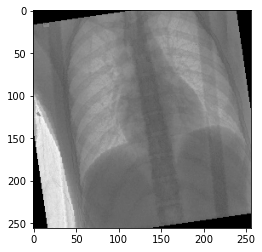

In [69]:
plt.imshow(images[4].reshape(256,256,-1), cmap = 'gray')

In [70]:
predictions = model(images)
predictions.shape

torch.Size([16, 22])

In [71]:
predictions

tensor([[1.5923e-03, 1.9614e-03, 1.1220e-01, 3.5013e-03, 1.0408e-07, 8.4204e-05,
         1.0522e-03, 7.4289e-11, 1.7023e-07, 8.9020e-08, 3.1936e-03, 3.1790e-04,
         2.0707e-04, 4.6215e-02, 5.8261e-01, 1.6733e-06, 1.1987e-05, 1.1666e-04,
         8.7695e-06, 1.9361e-06, 4.9678e-03, 1.6711e-05],
        [2.6509e-04, 2.8781e-04, 2.6685e-05, 9.9750e-01, 7.1334e-12, 9.3380e-07,
         6.7313e-03, 1.7676e-07, 3.9279e-11, 2.8586e-05, 5.1673e-05, 4.4602e-10,
         1.6921e-10, 1.4990e-02, 1.6494e-04, 1.2979e-11, 1.5888e-08, 1.4489e-06,
         2.6762e-09, 2.1492e-11, 4.8940e-03, 3.5946e-06],
        [1.0815e-04, 2.0884e-10, 4.3983e-08, 1.0000e+00, 1.8357e-16, 1.9905e-13,
         4.5327e-07, 1.8035e-10, 1.1714e-16, 1.5362e-08, 2.0292e-06, 1.3725e-14,
         2.0111e-15, 4.1429e-06, 7.1457e-08, 1.6253e-12, 1.3844e-10, 1.6731e-10,
         1.0384e-13, 7.2982e-14, 6.4754e-07, 2.4282e-09],
        [2.9214e-08, 9.1505e-14, 3.9545e-09, 1.0000e+00, 1.5815e-24, 2.1019e-17,
         9.3949e

In [72]:
predictions.max(dim = 1)

torch.return_types.max(
values=tensor([0.5826, 0.9975, 1.0000, 1.0000, 1.0000, 0.9975, 0.9261, 0.9803, 0.9805,
        0.9933, 1.0000, 0.9999, 1.0000, 0.9812, 1.0000, 0.5962],
       grad_fn=<MaxBackward0>),
indices=tensor([14,  3,  3,  3,  3,  3, 20,  2,  6,  6,  3, 15,  3,  2,  3,  8]))

In [73]:
predictions[predictions>0.5] = 1
predictions[predictions<0.5] = 0

In [74]:
predictions=predictions.detach().numpy()

In [75]:
multilabel_encoder.inverse_transform(predictions), multilabel_encoder.inverse_transform(labels)

([(14,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (13, 20),
  (2,),
  (6,),
  (6,),
  (3,),
  (15,),
  (3,),
  (2,),
  (3,),
  (8,)],
 [(14,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (13, 20),
  (2,),
  (6,),
  (6,),
  (3,),
  (15,),
  (3,),
  (2,),
  (3,),
  (8,)])

In [76]:
accuracy_score(labels.numpy(), predictions)

1.0

In [77]:
multilabel_confusion_matrix(labels.numpy(), predictions)

array([[[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[14,  0],
        [ 0,  2]],

       [[ 8,  0],
        [ 0,  8]],

       [[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[14,  0],
        [ 0,  2]],

       [[16,  0],
        [ 0,  0]],

       [[15,  0],
        [ 0,  1]],

       [[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[15,  0],
        [ 0,  1]],

       [[15,  0],
        [ 0,  1]],

       [[15,  0],
        [ 0,  1]],

       [[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[16,  0],
        [ 0,  0]],

       [[15,  0],
        [ 0,  1]],

       [[16,  0],
        [ 0,  0]]], dtype=int64)

In [56]:
state_dict_model = torch.load('model_save.pt')
print(state_dict_model.keys())
model.load_state_dict(state_dict_model)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


<All keys matched successfully>

In [57]:
train_accuracy = 0
val_accuracy = 0
for images, labels in tqdm(train_loader):
    predictions = model(images)
    predictions[predictions>0.5] = 1
    predictions[predictions<0.5] = 0
    predictions = predictions.detach().numpy()
    acc = accuracy_score(labels.numpy(), predictions)
    train_accuracy +=acc

for images, labels in tqdm(val_loader):
    predictions = model(images)
    predictions[predictions>0.5] = 1
    predictions[predictions<0.5] = 0
    predictions = predictions.detach().numpy()
    acc = accuracy_score(labels.numpy(), predictions)
    val_accuracy +=acc

100%|██████████| 33/33 [00:15<00:00,  2.08it/s]


In [84]:
print(f'Training accuracy {train_accuracy/len(train_loader)}')
print(f'validation accuracy {val_accuracy/len(val_loader)}')

Training accuracy 0.7256493506493507
validation accuracy 0.6353114478114479


In [59]:
f1_score(labels, predictions, average= 'samples')

0.6666666666666666